## Causal relation classification: using Transfer learning with a Pre-trained BERT model

### Causal relation classification: Trying to find is there a causal relation in the paragraph<br>

A fun example:
<img src="https://i1.wp.com/boingboing.net/wp-content/uploads/2020/11/Screen-Shot-2020-11-15-at-6.15.14-AM.png?fit=1208%2C786&ssl=1" style="width:400px;height:300px">


In this task, we will implement two models to classify whether a paragraph contains a causal relation. First of all, a pre-tained DistilBERT will process the paragraphs and pass along some information which can be used by a classifier. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.<br><br>
The classifier is a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either True or False (1 or 0, respectively). We can think of this of vector as an embedding for the sentence that we can use for classification.

### 1. Data preparation

Loading the data

In [1]:
cd ..

F:\PythonJupyterStudy\CM\CM_Macro\SSIML2021-macro-precision


In [2]:
from collections import OrderedDict 
import itertools
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.utils import shuffle,resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from src.data.make_dataset import read_data_file,make_dataset
import torch
import transformers as ppb
import warnings
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

In [3]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [5]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### 2. Balance the data

1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.

In [6]:
def balance_data(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=42,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('We totally have {} data after oversampling '.format(len(df_upsampled)))
    
    #downsampling
    df_true_downsampled = resample(df_true,random_state=42,n_samples=len(df_false),replace=False)
    df_downsampled = pd.concat([df_true_downsampled,df_false])
    df_downsampled = shuffle(df_downsampled)
    print('We totally have {} data after Undersampling '.format(len(df_downsampled)))
    
    
    return df_upsampled,df_downsampled

In [7]:
df_upsampled,df_downsampled = balance_data(X,y)

19 na data found
na data dropped
We totally have 1282 data after oversampling 
We totally have 474 data after Undersampling 


### 3. Transfer learning with a Pre-trained BERT model
Our first step is to tokenize the paragraphs -- break them up into word and subwords in the format BERT is comfortable with. This process contains adding [CLS] and [SEP] tokens as well as substituting tokens with their IDs (tokens2IDs). <br><br>After tokenization, tokenized is a list of paragraphs -- each paragraph is represented as a list of tokens. And we want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths). <br><br>However, if we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. Finally, we will get our features from the last hidden state of BERT, and use them as the input to our classifier.

#### Let's now load a pre-trained BERT model.

In [8]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).cuda() #use .cpu here if you dont have GPU

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Using bert to get the last_hidden_states

In [9]:
def chunks(lst, n):
    """Using this to do batching"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_max_len(batch):
    """
    use this to get the max length of all paragraphs in order to do the padding.
    """
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

def get_last_hidden_states(batch,max_len):
    """
    do Tokenization, Padding, and creating attention mask, then get the features from the last hidden states of BERT.
    Due to the GPU memory limitation, we will do this using batch.
    Input: data(in batch)
    output: features(in batch)
    """
    #Tokenization
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    #Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #here max_len-len(i)=509 is the maximal length
    #use attention_mask to ignore (mask) the padding we've added when it's processing its input
    attention_mask = np.where(padded != 0, 1, 0)
    #tokens to IDs (then convert them to cuda)
    input_ids = torch.tensor(padded).cuda() #use .cpu here if you dont have GPU
    attention_mask = torch.tensor(attention_mask).cuda() #use .cpu here if you dont have GPU
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    #Get the features from the last hidden states
    features = last_hidden_states[0][:,0,:].cpu().numpy()
    return (features,batch)
        
def get_features(batch_1):
    """
    Get features from the last hidden states of BERT, we do this using batch.
    Input: whole data
    output: whole features
    """
    batch_size = 64
    f_cat = np.array([]) #array used to concat batches
    batch_turns = len(list(chunks(batch_1[:],batch_size)))
    max_len = get_max_len(batch_1) #get the maximal length of paragraphs
    for b in range(batch_turns):
        print(f"Processed {b/batch_turns}")
        batch = list(chunks(batch_1[:],batch_size))[b]
        features,_ = get_last_hidden_states(batch,max_len)   
        f_cat =  np.concatenate((f_cat, features), axis=0)if f_cat.size else features
        print('The shape of features(in batch) is {}'.format(f_cat.shape))
    return f_cat 

### Now use the features from the hidden states of BERT to feed a simple Logistic regression classifier

In [10]:
def eval_k_fold(features,labels):
    """
    Use the features from the hidden states of BERT to feed a simple Logistic regression classifier.
    We do this by 10-fold cross-validation: split data to 10 folds, then train the model using training
    -set and evaluate it using test data. 
    Note: we will store all predictions and then use them to evaluate, which in sure that we could get an overall result.
    """
    kf = KFold(n_splits=10)
    kf.get_n_splits(features)
    y_pred = []
    y_true = []
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        lr=LogisticRegression()
        lr.fit(X_train, y_train)
        y_pred.extend(lr.predict(X_test))
        y_true.extend(y_test)
        
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)
    return

* Non-balanced data

19 na data found
Processed 0.0
The shape of features(in batch) is (64, 768)
Processed 0.07142857142857142
The shape of features(in batch) is (128, 768)
Processed 0.14285714285714285
The shape of features(in batch) is (192, 768)
Processed 0.21428571428571427
The shape of features(in batch) is (256, 768)
Processed 0.2857142857142857
The shape of features(in batch) is (320, 768)
Processed 0.35714285714285715
The shape of features(in batch) is (384, 768)
Processed 0.42857142857142855
The shape of features(in batch) is (448, 768)
Processed 0.5
The shape of features(in batch) is (512, 768)
Processed 0.5714285714285714
The shape of features(in batch) is (576, 768)
Processed 0.6428571428571429
The shape of features(in batch) is (640, 768)
Processed 0.7142857142857143
The shape of features(in batch) is (704, 768)
Processed 0.7857142857142857
The shape of features(in batch) is (768, 768)
Processed 0.8571428571428571
The shape of features(in batch) is (832, 768)
Processed 0.9285714285714286
The s

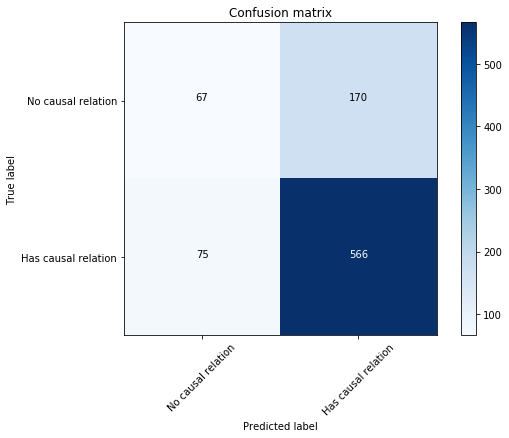

In [11]:
#non-balanced data
df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
df = df.dropna()
features = get_features(df)
labels = df['y']
eval_k_fold(features,labels)

* Oversampling

Processed 0.0
The shape of features(in batch) is (64, 768)
Processed 0.047619047619047616
The shape of features(in batch) is (128, 768)
Processed 0.09523809523809523
The shape of features(in batch) is (192, 768)
Processed 0.14285714285714285
The shape of features(in batch) is (256, 768)
Processed 0.19047619047619047
The shape of features(in batch) is (320, 768)
Processed 0.23809523809523808
The shape of features(in batch) is (384, 768)
Processed 0.2857142857142857
The shape of features(in batch) is (448, 768)
Processed 0.3333333333333333
The shape of features(in batch) is (512, 768)
Processed 0.38095238095238093
The shape of features(in batch) is (576, 768)
Processed 0.42857142857142855
The shape of features(in batch) is (640, 768)
Processed 0.47619047619047616
The shape of features(in batch) is (704, 768)
Processed 0.5238095238095238
The shape of features(in batch) is (768, 768)
Processed 0.5714285714285714
The shape of features(in batch) is (832, 768)
Processed 0.6190476190476191
The

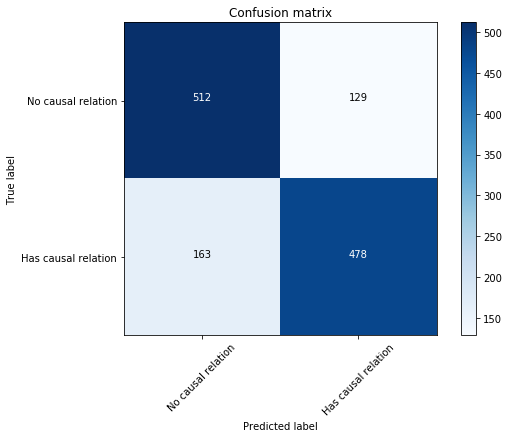

In [12]:
features_upsampled = get_features(df_upsampled)
labels_upsampled = df_upsampled['y']
eval_k_fold(features_upsampled,labels_upsampled)

* Undersampling

Processed 0.0
The shape of features(in batch) is (64, 768)
Processed 0.125
The shape of features(in batch) is (128, 768)
Processed 0.25
The shape of features(in batch) is (192, 768)
Processed 0.375
The shape of features(in batch) is (256, 768)
Processed 0.5
The shape of features(in batch) is (320, 768)
Processed 0.625
The shape of features(in batch) is (384, 768)
Processed 0.75
The shape of features(in batch) is (448, 768)
Processed 0.875
The shape of features(in batch) is (474, 768)
              precision    recall  f1-score   support

     class 0       0.65      0.64      0.64       237
     class 1       0.64      0.66      0.65       237

    accuracy                           0.65       474
   macro avg       0.65      0.65      0.65       474
weighted avg       0.65      0.65      0.65       474



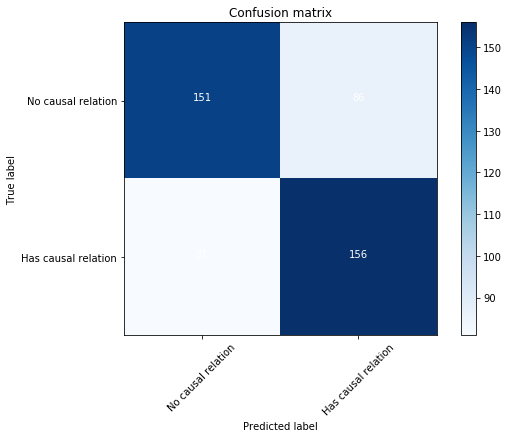

In [13]:
features_downsampled = get_features(df_downsampled)
labels_downsampled = df_downsampled['y']
eval_k_fold(features_downsampled,labels_downsampled)

## Comparison with n-gram(non-contextual word embedding)


Bert/n-gram| Balanced_data | macro precision | macro recall | macro F1|
 ----------| -----------------------| --------- | ------ | ---- |
Bert            | no         | 0.62     | 0.58 | 0.59 |
Bert            | Oversampling   | 0.78     | 0.77 | 0.77 |
Bert            | Undersampling   | 0.65     | 0.65 | 0.65 |
3-gram           | no           | 0.87     | 0.51  | 0.44 |
3-gram(pre-trained WE)| Oversampling   | 0.66     | 0.57  | 0.57 |
3-gram(pre-trained WE)| undersampling   | 0.66    | 0.66 | 0.66 |


#### To sum up:<br>
* Attention is all you need! With oversampled data, Bert approach can achieve 0.77 macro F1 score.<br>
* However, both balancing methods have their advantages and disadvantages, where undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.<br>
* The next step would be to try [fine-tuning](https://huggingface.co/transformers/examples.html#glue) once we have more data